# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Idea" data-toc-modified-id="Idea-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Idea</a></div><div class="lev2 toc-item"><a href="#Inverse-Model" data-toc-modified-id="Inverse-Model-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Inverse Model</a></div><div class="lev1 toc-item"><a href="#The-game" data-toc-modified-id="The-game-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The game</a></div><div class="lev2 toc-item"><a href="#The-environment" data-toc-modified-id="The-environment-21"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>The environment</a></div>

# Idea

## Inverse Model

Bayesian rat. 
- Parameters
    - Learning Rate
    - Weber Fixed
    - Discounting
    

# The game

## The environment

In [3]:
import os
os.chdir('../../')

In [4]:
from itertools import count
import scipy.stats as st
import numpy as np

In [5]:
class DRRD():
    """
    
    """
    def __init__(self, criterion):
        # Time in seconds
        self.criterion = criterion
        self.action_history_ = []
        self.reward_history_ = []
        self.criterion_history = []
        
    def _reward(self, time):
        if time > self.criterion:
            return True
        else:
            return False
        
    def _store(self, action, reward, criterion):
        self.action_history_.append(action)
        self.reward_history_.append(reward)
        self.criterion_history.append(criterion)
        
    def play(self, Rat, max_rounds=1000):
        for r in range(max_rounds):
            action = Rat.act()
            reward = self._reward(action)
            self._store(action, reward, self.criterion)
            Rat.get_reward(reward)
            if Rat.tired_: break
                

                

class BayesianRat():
    """
    
    """
    def __init__(self, learning_rate=.01, discounting=0, weber=.15, 
                    likelihood_dist='normal', range=(0,6), dt=1e-3, 
                    prior='lognormal' , responses=None, rule='like'):
        
        self.weber = weber
        self.discounting = discounting
        self.learning_rate = learning_rate
        self.update_rule = rule
        self.dt = dt
        
        self.sup = np.arange(range[0], range[1], dt)
        
        
        self.prior_ = self._make_prior(prior)
        self.cdf_ = self.prior_.cumsum()
        self.prior_history = [self.prior_]
        self.likely_history = []
        
        
        self.likelihood_dist_ = self._make_lh(prior)
        
        self.model_logL_ = 0
        self.last_response_ = None
        self.responses = responses
        
        self.tired_ = False
        
    
    def _make_prior(self, prior):
        if prior == 'lognormal':
            return st.lognorm(scale=1, s=1).pdf(self.sup)*self.dt
        elif isinstance(prior, np.array):
            assert len(prior) == len(self.sup)
            assert prior.sum()== 1/dt
            return prior
    
    def _make_lh(self, likelihood_dist):
        if likelihood_dist == 'lognormal':
            return lambda t: st.lognorm(scale=t, s=self.weber).pdf(self.sup)
        elif likelihood_dist == 'normal':
            return lambda t: st.norm(loc=t, scale=self.weber*t).pdf(self.sup)
        
    def act(self):
        if self.responses is not None:
            self.last_response_ = self.responses.pop(0)
            if len(self.responses) == 0:
                self.tired = True
        else:
            self.last_response_ = self._sample_action()
        
        self.model_logL_ += np.log(self._model_likelihood(self.last_response_))
        return self.last_response_
    
    def _sample_action(self):
        return self.sup[np.abs(self.cdf_ - np.random.rand()).argmin()]
        
    def get_reward(self, reward):
        if reward:
            self._update_prior(np.exp(- self.discounting * self.last_response_))
    
    def _update_prior(self, reward_value):
        likely_time = self._time_likelihood(self.last_response_)
        self.likely_history.append(likely_time)
        
        if self.update_rule == 'like':
            update = likely_time
        elif self.update_rule == 'post':
            update = self.prior_ * likely_time
        
        lr = self.learning_rate * reward_value
        
        self.prior_ = self.prior_*(1-lr) + update*lr
        self.prior_ /= self.prior_.sum()
        self.cdf_ = self.prior_.cumsum()
        
        self.prior_history.append(self.prior_)
        
    def _time_likelihood(self, time):
        lkl = self.likelihood_dist_(time)
        return lkl/lkl.sum()
    
    def _model_likelihood(self, response):
        return self.prior_[np.abs(self.sup - response).argmin()]
        

class GallistelRat():
    """
    
    """
    pass

        

In [39]:
bayes = BayesianRat(discounting=1.5, learning_rate=.05)

In [40]:
task = DRRD(1.5)

In [41]:
task.play(bayes, 1000)

In [9]:
from spikelearn.visuals.visuals import singleRatBehaviorPlot
from spikelearn.data.utils import reyes_cp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

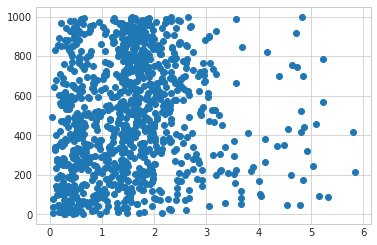

In [42]:
plt.scatter(task.action_history_,np.arange(1000))

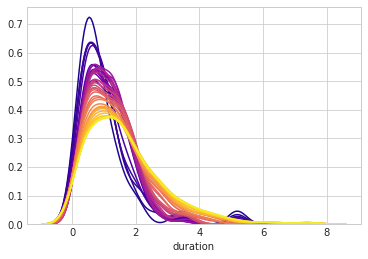

In [86]:
for i in range(N):
    sns.distplot(behav.duration[int(i*.8):i*10+30], hist=False, color=c[i])

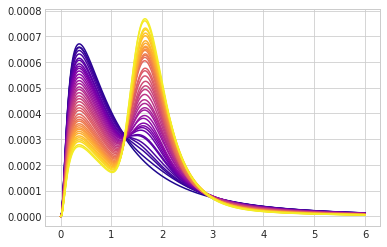

In [43]:
N=40
c = sns.color_palette('plasma', N)

for i in range(N):
    plt.plot(bayes.sup, bayes.prior_history[10*i], color=c[i])

/home/registroeletrofisio/miniconda3/envs/ratLearn/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/registroeletrofisio/miniconda3/envs/ratLearn/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


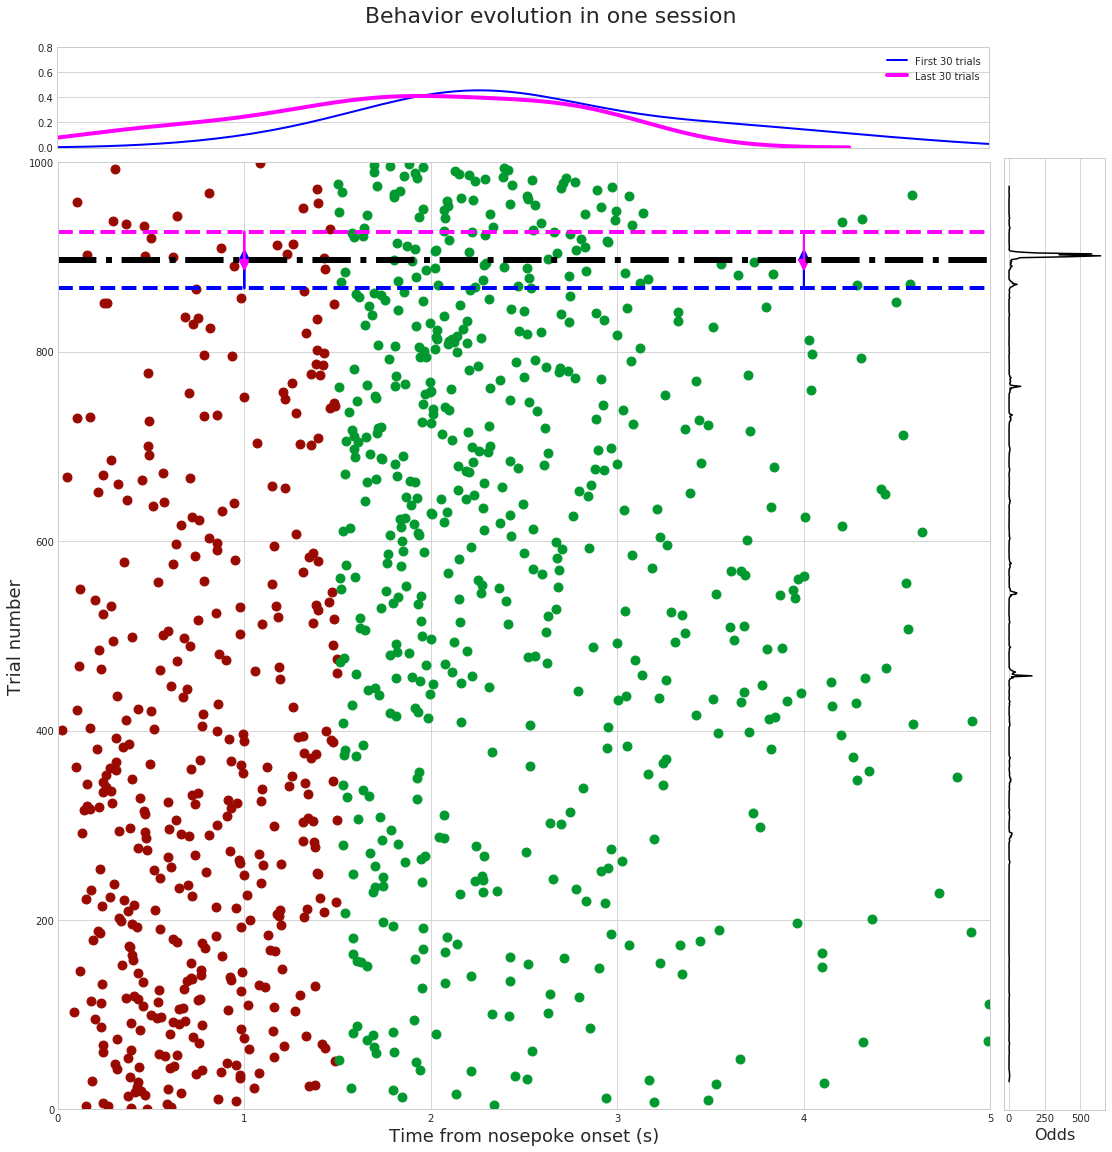

In [12]:
singleRatBehaviorPlot(np.array(task.action_history_), reyes_cp(task.action_history_), kde='cp', kdeN=30)

---

In [15]:
from spikelearn.data import io
from itertools import product
import pandas as pd
from tqdm import tqdm

In [37]:
%%time
behav = io.load('DRRD 7', 'behavior')
discounts = np.linspace(1e-3,3,5).round(3)
lrates = np.linspace(1e-3,.1,5).round(3)

logL = np.full((len(discounts),len(lrates)), np.nan)
pbar = lambda x: tqdm(x, total=len(discounts)*len(lrates))

for (i, discount), (j, learning_rate) in pbar(product(enumerate(discounts), enumerate(lrates))):
    bm = BayesianRat(responses=list(behav.duration.values), learning_rate=learning_rate, discounting=discount)
    task = DRRD(1.5)
    task.play(bm)
    logL[i,j] = bm.model_logL_
    del(bm)

logL = pd.DataFrame(logL, index=pd.Index(discounts, name='Discount'), columns=pd.Index(lrates, name='Learning Rate'))


100%|██████████| 25/25 [01:12<00:00,  2.88s/it]


CPU times: user 26.6 s, sys: 1 s, total: 27.6 s
Wall time: 1min 12s


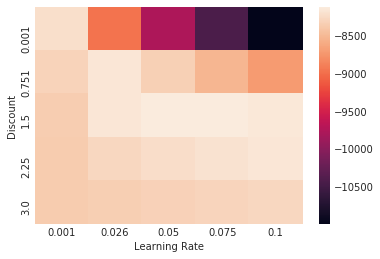

In [38]:
sns.heatmap(logL)

In [114]:
%%time
behav = io.load('DRRD 7', 'behavior')
lrates = np.linspace(1e-5,1e-2,30).round(5)

logL = np.full((1,len(lrates)), np.nan)
pbar = lambda x: tqdm(x, total=len(lrates), leave=True)

for (j, learning_rate) in pbar(enumerate(lrates)):
    bm = BayesianRat(responses=list(behav.duration.values), learning_rate=learning_rate, discounting=0)
    task = DRRD(1.5)
    task.play(bm)
    logL[0,j] = bm.model_logL_
    del(bm)

logL = pd.DataFrame(logL, index=[0], columns=pd.Index(lrates, name='Learning Rate'))



  0%|          | 0/30 [00:00<?, ?it/s]

  3%|▎         | 1/30 [00:00<00:24,  1.21it/s]

  7%|▋         | 2/30 [00:01<00:22,  1.23it/s]

 10%|█         | 3/30 [00:02<00:22,  1.23it/s]

 13%|█▎        | 4/30 [00:03<00:20,  1.24it/s]

 17%|█▋        | 5/30 [00:04<00:20,  1.24it/s]

 20%|██        | 6/30 [00:04<00:19,  1.23it/s]

 23%|██▎       | 7/30 [00:05<00:18,  1.23it/s]

 27%|██▋       | 8/30 [00:06<00:17,  1.23it/s]

 30%|███       | 9/30 [00:07<00:17,  1.23it/s]

 33%|███▎      | 10/30 [00:08<00:16,  1.23it/s]

 37%|███▋      | 11/30 [00:09<00:16,  1.19it/s]

 40%|████      | 12/30 [00:10<00:16,  1.10it/s]

 43%|████▎     | 13/30 [00:13<00:17,  1.02s/it]

 47%|████▋     | 14/30 [00:14<00:16,  1.03s/it]

 50%|█████     | 15/30 [00:16<00:16,  1.10s/it]

 53%|█████▎    | 16/30 [00:19<00:16,  1.19s/it]

 57%|█████▋    | 17/30 [00:20<00:15,  1.21s/it]

 60%|██████    | 18/30 [00:22<00:15,  1.25s/it]

 63%|██████▎   | 19/30 [00:24<00:14,  1.29s/it]

 67%|██████▋   | 20/30 [00:25<00:12,

CPU times: user 27.6 s, sys: 736 ms, total: 28.4 s
Wall time: 43.9 s


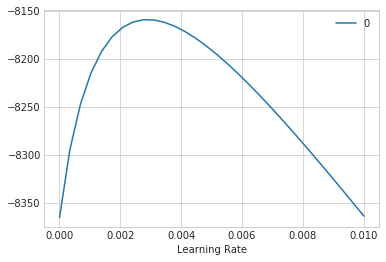

In [115]:
logL.transpose().plot()

---

In [98]:
prior = st.lognorm(scale=4, s=.15).pdf(sup)

In [26]:
cdf = prior.cumsum().reshape(-1,1)
cdf/=cdf.max()

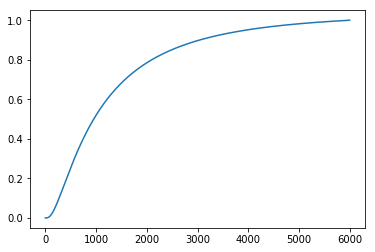

In [27]:
plt.plot(cdf)

In [44]:
N = 1000
s = sup[np.abs(cdf-np.random.random(size=(1,N))).argmin(axis=0)]

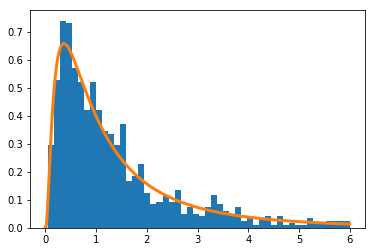

In [45]:
plt.hist(s,50, density=True);
plt.plot(sup, prior, linewidth=3)

In [47]:
s.mean()

1.3459909999999999

- Taxa média
- Bracketing